In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR 
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer 

In [28]:
sequence_length = 24 * 7 
train_data_share = 0.8

df = pd.read_csv('AirQualityUCI.csv', sep=",")

df.drop(columns=['Unnamed: 15', 'Unnamed: 16'],inplace=True)
df.dropna(inplace=True)
df.drop(columns=['NMHC(GT)'],inplace=True)
df.replace(to_replace=-200,value=np.nan,inplace=True)
for column in df.columns:
    if df[column].dtype == 'float64':
        df.fillna({column:df[column].mean()}, inplace=True)

df.head()


,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10-03-2004,18:00:00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10-03-2004,19:00:00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10-03-2004,20:00:00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10-03-2004,21:00:00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10-03-2004,22:00:00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [29]:
df.isnull().sum()

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

In [31]:
# Step 1: Verify the columns after reading the data
print("Initial columns in the dataset:", df.columns)

# Step 2: Apply the replacement on numeric columns
# Define the numeric columns that may contain commas as decimal separators
numeric_columns = ['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 
                   'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 
                   'PT08.S5(O3)', 'T', 'RH', 'AH']

# Apply the replacement and conversion only on the numeric columns
df[numeric_columns] = df[numeric_columns].replace(',', '.', regex=True).apply(pd.to_numeric, errors='coerce')

# Step 3: Verify the data after applying the conversion
print("Data after applying the replacements and conversion:")
print(df.head())




Initial columns in the dataset: Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH'],
      dtype='object')
Data after applying the replacements and conversion:
         Date      Time  CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  \
0  10-03-2004  18:00:00     2.6       1360.0      11.9         1046.0   
1  10-03-2004  19:00:00     2.0       1292.0       9.4          955.0   
2  10-03-2004  20:00:00     2.2       1402.0       9.0          939.0   
3  10-03-2004  21:00:00     2.2       1376.0       9.2          948.0   
4  10-03-2004  22:00:00     1.6       1272.0       6.5          836.0   

   NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH  \
0    166.0        1056.0    113.0        1692.0       1268.0  13.6  48.9   
1    103.0        1174.0     92.0        1559.0        972.0  13.3  47.7   
2    131.0        1140.0    114.0        1555.0 

In [32]:
# Step 1: Convert 'Date' and 'Time' columns into a datetime format
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d-%m-%Y %H:%M:%S')

# Step 2: Drop the original 'Date' and 'Time' columns
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Step 3: Extract useful datetime features (hour, day of week, etc.)
df['Hour'] = df['Datetime'].dt.hour
df['DayOfWeek'] = df['Datetime'].dt.dayofweek
df['Month'] = df['Datetime'].dt.month

# Step 4: Drop 'Datetime' column as it's no longer needed
df.drop(['Datetime'], axis=1, inplace=True)

df.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Hour,DayOfWeek,Month
0,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,18,2,3
1,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,19,2,3
2,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,20,2,3
3,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,21,2,3
4,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,22,2,3


In [33]:
# Define the features (X) and target (y) variable
X = df.drop(['CO(GT)'], axis=1)  # Assuming CO(GT) is the target variable
y = df['CO(GT)']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [35]:
print(X_train.shape)
print(X_test.shape)

(7485, 14)
(1872, 14)


In [36]:
df.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Hour,DayOfWeek,Month
0,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,18,2,3
1,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,19,2,3
2,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,20,2,3
3,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,21,2,3
4,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,22,2,3


TRAINING

In [37]:
# Initialize Support Vector Regressor
svr = SVR(kernel='rbf')

# Train the model
svr.fit(X_train, y_train)


SVR()

In [38]:
# Make predictions on test set
y_pred_train = svr.predict(X_train)
y_pred_test = svr.predict(X_test)


In [39]:
# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Training RMSE: {rmse_train}")
print(f"Testing RMSE: {rmse_test}")


Training RMSE: 0.591179841559429
Testing RMSE: 0.5848960530502216


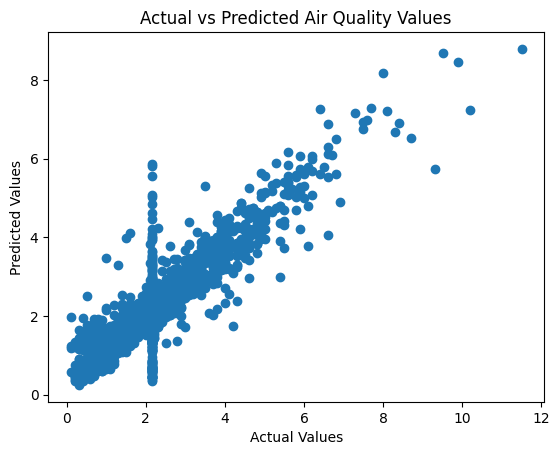

In [41]:
# Plot Actual vs Predicted values
plt.scatter(y_test, y_pred_test)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Air Quality Values")
plt.show()


TESTING

In [25]:
import random

# Assuming svr_model is your trained Support Vector Regressor (SVR)
# Get a random index from the test set
random_index = random.randint(0, len(X_test) - 1)

# Extract the random row
random_row = X_test.iloc[random_index]

# Print all parameters from the random row
print(f"Random Test Row {random_index + 1}:")
print(random_row)

# Extract the row for prediction (convert it to the required format)
row_for_prediction = random_row.values.reshape(1, -1)

# Make prediction for air quality
predicted_air_quality = svr.predict(row_for_prediction)[0]

# Display the predicted air quality
print(f"\nPredicted Air Quality: {predicted_air_quality}")

# Classify the air quality
if predicted_air_quality <= 0.6:
    air_quality_status = "Good"
elif 0.5 <= predicted_air_quality < 1.5:
    air_quality_status = "Average"
else:
    air_quality_status = "Bad"

# Display the classification
print(f"Air Quality Status: {air_quality_status}")


Random Test Row 1546:
PT08.S1(CO)      1152.0000
C6H6(GT)           13.6000
PT08.S2(NMHC)    1104.0000
NOx(GT)           145.0000
PT08.S3(NOx)      725.0000
NO2(GT)            99.0000
PT08.S4(NO2)     1860.0000
PT08.S5(O3)      1023.0000
T                  21.5000
RH                 47.9000
AH                  1.2178
Hour               12.0000
DayOfWeek           1.0000
Month               5.0000
Name: 1314, dtype: float64

Predicted Air Quality: 2.3231853501193713
Air Quality Status: Bad


c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
